# 14-14. 프로젝트: 한국어 데이터로 챗봇 만들기

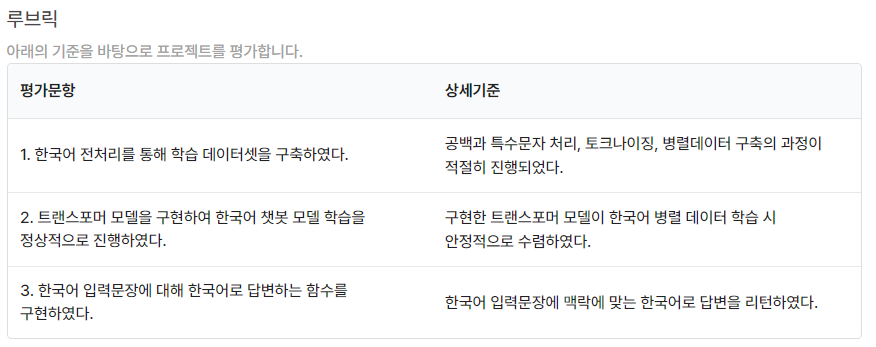

영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.

시작하기 전에 우선 주요 라이브러리 버전을 확인해 봅시다.

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf

### Step 1. 데이터 수집하기
----
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.


- [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)


Cloud shell에서 아래 명령어를 입력해 주세요.


```bash
$ mkdir -p ~/aiffel/transformer_chatbot/data/
$ ln -s ~/data/* ~/aiffel/transformer_chatbot/data/
```

In [3]:
train_data = pd.read_csv('./data/ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


### Step 2. 데이터 전처리하기
----
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

In [4]:
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [6]:
questions = []
for sentence in train_data['Q']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [7]:
answers = []
for sentence in train_data['A']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [8]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


### Step 3. SubwordTextEncoder 사용하기
---
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

In [9]:
# 서브워드텍스트인코더를 사용하여 질문, 답변 데이터로부터 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [10]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [11]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8178]
종료 토큰 번호 : [8179]
단어 집합의 크기 : 8180


In [12]:
print(questions[20])

가스비 비싼데 감기 걸리겠어


In [13]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('원 질문 출력:', questions[20])
print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(questions[20])))

원 질문 출력: 가스비 비싼데 감기 걸리겠어
임의의 질문 샘플을 정수 인코딩 : [5766, 611, 3509, 141, 685, 3747, 849]


In [14]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5766, 611, 3509, 141, 685, 3747, 849]
기존 문장: 가스비 비싼데 감기 걸리겠어


In [15]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5766 ----> 가스
611 ----> 비 
3509 ----> 비싼
141 ----> 데 
685 ----> 감기 
3747 ----> 걸리
849 ----> 겠어


In [16]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    # 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [17]:
questions, answers = tokenize_and_filter(questions, answers)

In [18]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 40)
답변 데이터의 크기(shape) : (11823, 40)


In [19]:
# 0번 샘플을 임의로 출력
print(questions[0])
print(answers[0])

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [20]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [21]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


### Step 4. 모델 구성하기
----
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

#### 1. 포지셔널 인코딩 레이어

In [22]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(position=tf.range(position, dtype=tf.float32)
                                     [:, tf.newaxis], i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


#### 2. 스케일드 닷 프로덕트 어텐션

In [23]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

print("슝=3")

슝=3


#### 3. 멀티헤드 어텐션

In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs
    
print("슝=3")

슝=3


#### 4. 마스킹
##### 1) 패딩 마스킹

In [25]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


##### 2) 룩 어헤드 마스킹

In [26]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

print("슝=3")

슝=3


#### 5. 인코더
##### 1) 인코더 레이어 구현

In [27]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({'query': inputs, 'key': inputs, 'value': inputs, 'mask': padding_mask})

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

print("슝=3")

슝=3


##### 2) 인코더레이어 쌓아 인코더 구현

In [28]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(units=units, 
                                d_model=d_model, 
                                num_heads=num_heads, dropout=dropout, name="encoder_layer_{}".format(i),)([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

print("슝=3")

슝=3


#### 6. 디코더
##### 1) 디코더 레이어 구현

In [29]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={'query': inputs, 'key': inputs,'value': inputs,'mask': look_ahead_mask})

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={'query': attention1, 
                                                        'key': enc_outputs, 'value': enc_outputs, 'mask': padding_mask})

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

print("슝=3")

슝=3


##### 2) 디코더레이어를 쌓아 디코더 구현

In [30]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units, d_model=d_model, num_heads=num_heads, dropout=dropout, name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

print("슝=3")

슝=3


#### 6. 트랜스포머 모델 정의

In [31]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

print("슝=3")

슝=3


In [36]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3148288     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### Step 5. 모델 평가하기
----
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

#### 1) 손실함수

In [38]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

print("슝=3")

슝=3


#### 2) 커스텀 학습률

In [39]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

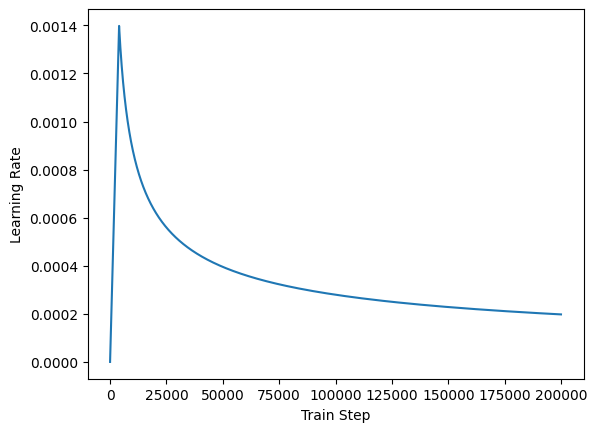

In [40]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### 3) 모델 컴파일

In [41]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

print("슝=3")

슝=3


#### 4) 학습
- 일단 테스트 학습을 진행해본다. 

In [42]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 11s 34ms/step - loss: 1.4630 - accuracy: 0.0278
Epoch 2/10
185/185 [==============================] - 6s 34ms/step - loss: 1.1899 - accuracy: 0.0495
Epoch 3/10
185/185 [==============================] - 6s 34ms/step - loss: 1.0072 - accuracy: 0.0507
Epoch 4/10
185/185 [==============================] - 6s 34ms/step - loss: 0.9298 - accuracy: 0.0544
Epoch 5/10
185/185 [==============================] - 6s 33ms/step - loss: 0.8708 - accuracy: 0.0577
Epoch 6/10
185/185 [==============================] - 6s 33ms/step - loss: 0.8114 - accuracy: 0.0617
Epoch 7/10
185/185 [==============================] - 6s 34ms/step - loss: 0.7453 - accuracy: 0.0677
Epoch 8/10
185/185 [==============================] - 6s 34ms/step - loss: 0.6719 - accuracy: 0.0754
Epoch 9/10
185/185 [==============================] - 6s 33ms/step - loss: 0.5923 - accuracy: 0.0842
Epoch 10/10
185/185 [==============================] - 6s 33ms/step - loss: 0.5085 - accur

#### 5) 모델 평가
- 챗봇테스트 준비

In [47]:
def preprocess_sentence(sentence):
    # 단어와 구두점 사이에 공백 추가.
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

In [48]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

print("슝=3")

슝=3


In [49]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

print("슝=3")

슝=3


In [50]:
sentence_generation('안녕하세요?')

입력 : 안녕하세요?
출력 : 저는 위로해드리는 로봇이에요 .


'저는 위로해드리는 로봇이에요 .'

In [51]:
sentence_generation('당신의 이름을 알려주세요')

입력 : 당신의 이름을 알려주세요
출력 : 이제 일어날 시간이에요 .


'이제 일어날 시간이에요 .'

#### 소결론1
- 일단 논리적인 답변을 하나
- 맥락과 잘 맞는 답을 하지는 못하는 듯 하다. 
- 학습을 좀더 많이 진행해보기로 한다. 

In [54]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3148288     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [55]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

print("슝=3")

슝=3


In [56]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
185/185 [==============================] - 9s 34ms/step - loss: 1.4502 - accuracy: 0.0239
Epoch 2/100
185/185 [==============================] - 6s 34ms/step - loss: 1.1734 - accuracy: 0.0496
Epoch 3/100
185/185 [==============================] - 6s 34ms/step - loss: 0.9998 - accuracy: 0.0506
Epoch 4/100
185/185 [==============================] - 6s 34ms/step - loss: 0.9260 - accuracy: 0.0544
Epoch 5/100
185/185 [==============================] - 6s 34ms/step - loss: 0.8685 - accuracy: 0.0579
Epoch 6/100
185/185 [==============================] - 6s 34ms/step - loss: 0.8098 - accuracy: 0.0619
Epoch 7/100
185/185 [==============================] - 6s 33ms/step - loss: 0.7452 - accuracy: 0.0675
Epoch 8/100
185/185 [==============================] - 6s 33ms/step - loss: 0.6731 - accuracy: 0.0751
Epoch 9/100
185/185 [==============================] - 6s 34ms/step - loss: 0.5946 - accuracy: 0.0840
Epoch 10/100
185/185 [==============================] - 6s 34ms/step - loss: 0.513

185/185 [==============================] - 7s 36ms/step - loss: 0.0027 - accuracy: 0.1743
Epoch 81/100
185/185 [==============================] - 6s 35ms/step - loss: 0.0027 - accuracy: 0.1743
Epoch 82/100
185/185 [==============================] - 6s 34ms/step - loss: 0.0026 - accuracy: 0.1744
Epoch 83/100
185/185 [==============================] - 7s 36ms/step - loss: 0.0025 - accuracy: 0.1744
Epoch 84/100
185/185 [==============================] - 6s 34ms/step - loss: 0.0026 - accuracy: 0.1744
Epoch 85/100
185/185 [==============================] - 6s 34ms/step - loss: 0.0027 - accuracy: 0.1743
Epoch 86/100
185/185 [==============================] - 6s 34ms/step - loss: 0.0025 - accuracy: 0.1744
Epoch 87/100
185/185 [==============================] - 6s 34ms/step - loss: 0.0025 - accuracy: 0.1744
Epoch 88/100
185/185 [==============================] - 6s 34ms/step - loss: 0.0025 - accuracy: 0.1743
Epoch 89/100
185/185 [==============================] - 6s 35ms/step - loss: 0.0024 - 

In [57]:
sentence_generation('안녕하세요?')

입력 : 안녕하세요?
출력 : 안녕하세요 .


'안녕하세요 .'

In [58]:
sentence_generation('당신의 이름을 알려주세요')

입력 : 당신의 이름을 알려주세요
출력 : 저처럼 연락 늦는 사람도 있어요 .


'저처럼 연락 늦는 사람도 있어요 .'

In [59]:
sentence_generation('오늘은 기분이 좋지 않아요')

입력 : 오늘은 기분이 좋지 않아요
출력 : 정말 많이 좋아했나봐요 .


'정말 많이 좋아했나봐요 .'

In [60]:
sentence_generation('원하던 학교에 가지 못하게 됐어요')

입력 : 원하던 학교에 가지 못하게 됐어요
출력 : 부모님이나 선생님께 도움을 청해보세요 .


'부모님이나 선생님께 도움을 청해보세요 .'

In [61]:
sentence_generation('맛있는 음식이 먹고 싶어요')

입력 : 맛있는 음식이 먹고 싶어요
출력 : 저도 진짜 힘들었는데 지금은 좋은 사람 만나 행복해요 .


'저도 진짜 힘들었는데 지금은 좋은 사람 만나 행복해요 .'

#### 소결론2
- 여전히 맥락에 맞지 않는 대답을 하는 경우가 많다
- 이번에는 하이퍼파라미터를 조정해서 학습을 진행한다. 
- epoch은 70정로 줄인다. 
- 학습 상황을 그래프로 그려본다. 

In [62]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
D_MODEL = 512
NUM_LAYERS = 4
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    10500096    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [63]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

print("슝=3")

슝=3


In [64]:
EPOCHS = 70
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/70
185/185 [==============================] - 19s 74ms/step - loss: 1.3496 - accuracy: 0.0283
Epoch 2/70
185/185 [==============================] - 14s 74ms/step - loss: 1.0657 - accuracy: 0.0496
Epoch 3/70
185/185 [==============================] - 13s 72ms/step - loss: 0.9722 - accuracy: 0.0519
Epoch 4/70
185/185 [==============================] - 13s 73ms/step - loss: 0.9189 - accuracy: 0.0553
Epoch 5/70
185/185 [==============================] - 14s 73ms/step - loss: 0.8615 - accuracy: 0.0589
Epoch 6/70
185/185 [==============================] - 13s 73ms/step - loss: 0.7949 - accuracy: 0.0636
Epoch 7/70
185/185 [==============================] - 14s 73ms/step - loss: 0.7205 - accuracy: 0.0708
Epoch 8/70
185/185 [==============================] - 14s 73ms/step - loss: 0.6404 - accuracy: 0.0793
Epoch 9/70
185/185 [==============================] - 14s 74ms/step - loss: 0.5588 - accuracy: 0.0889
Epoch 10/70
185/185 [==============================] - 14s 74ms/step - loss: 0.477

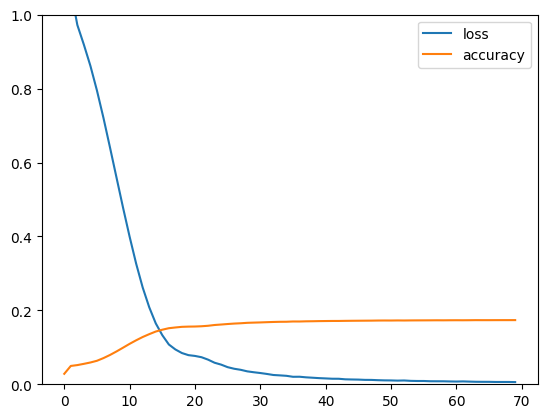

In [67]:
for k,v in history.history.items():
    plt.plot(history.history[k], label=k)
plt.ylim(0, 1.0)
plt.legend()

plt.show()

In [68]:
sentence_generation('안녕하세요?')

입력 : 안녕하세요?
출력 : 안녕하세요 .


'안녕하세요 .'

In [69]:
sentence_generation('당신의 이름을 알려주세요')

입력 : 당신의 이름을 알려주세요
출력 : 그럴 거예요 .


'그럴 거예요 .'

In [70]:
sentence_generation('오늘은 기분이 좋지 않아요')

입력 : 오늘은 기분이 좋지 않아요
출력 : 제가 가끔 그래요 .


'제가 가끔 그래요 .'

In [71]:
sentence_generation('원하던 학교에 가지 못하게 됐어요')

입력 : 원하던 학교에 가지 못하게 됐어요
출력 : 친구를 맞이할 준비를 해봐요 .


'친구를 맞이할 준비를 해봐요 .'

In [72]:
sentence_generation('맛있는 음식이 먹고 싶어요')

입력 : 맛있는 음식이 먹고 싶어요
출력 : 긍정적으로 바뀔 수 있어요


'긍정적으로 바뀔 수 있어요'

# 회고

### 신경쓴점
- 아직 모델에 대한 이해도가 높지 않아, 모델이 정상 작동하도록 구현하는데 노력했다. 
- 하이퍼 파라이터를 조절해가며 최대한 학습되도록 시도했다. 

### 아쉬운점
- 여러 시도에도 정확도가 드라마틱하게 올라가지 않는 점은 아마 데이터의 양이 적어서인듯 하다. 
- 모델을 좀더 뜯고 맛보고 했어야 하는데 그렇게 하지 못했다. 

### 시도해보고 싶은 점
- 좀더 많은 데이터를 확보해서 시도해 학습을 진행해보고 싶다. 

### 확인한점
- subword text encoder가 상당히 강력하다는 생각을 했다. 
- subword text encoder어떠한 원리로 subword를 찾고 분리하는지 원인을 공부해보고 싶어졌다. 

<br/>
<br/>

# reference
- lms
- 딥러닝을 이용한 자연어 처리 입문([링크](https://wikidocs.net/89786))